# TP Aprendizaje Automático 2
- Alsop Agustín (A-4651/7)
- Hachen Rocío (H-1184/3)

# Introducción

## Librerias

In [1247]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from matplotlib.lines import Line2D
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

## Funciones

In [1248]:
def simpleImputerPerMonth(x_train: pd.DataFrame, x_test: pd.DataFrame, imputer_method : str, columns : list) -> tuple:

    """
    Realiza la imputación de datos según la estrategia elegida, sobre las columnas seleccionadas, agrupando los datos por mes.

    Parámetros:
        x_train: Dataset de datos de entrenamiento
        x_test: Dataset de datos de prueba
        imputer_method: 
    
    Retorno: 
        Tupla que contiene los datos de entrenamientos imputados y los datos de prueba imputados.

    """

    methods = ['mean','median','most_frequent','constant']

    if imputer_method not in methods:
        raise ValueError(f'El imputer_method debe pertenecer a la lista de estrategias válidas: {methods}')
    
    for month in range(1, 13):
        
        imputer = SimpleImputer(strategy=imputer_method)
        
        # Filtramos el DataFrame por el mes y realizar la imputación
        train_filter = x_train['Date'].dt.month == month
        test_filter = x_test['Date'].dt.month == month
        
        x_train.loc[train_filter, columns] = imputer.fit_transform(x_train.loc[train_filter, columns])
        x_test.loc[test_filter, columns] = imputer.transform(x_test.loc[test_filter, columns])

    return(x_train, x_test)

def boxplots(X: pd.DataFrame,y : pd.DataFrame, columns : pd.Index ) -> None:

    """
    Gráfica boxplots según los datos otorgados

    Parámetros:
        X: Datos para visualizar en el eje X
        y: Datos para visualizar en el eje Y
        columns: Columnas a incluir

    """
    data = pd.concat([pd.DataFrame(y, columns=['RainTomorrow']), pd.DataFrame(X, columns=columns)], axis=1)

    num_features = X.shape[1]
    num_rows = num_features // 3 +1

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Se recorre cada feature para generar su diagrama de caja respecto de la salida
    for i, feature in enumerate(data.columns[1:]):
        row = i // 3
        col = i % 3
        sns.boxplot(x='RainTomorrow', y=feature, hue='RainTomorrow', data=data, ax=axes[row, col], palette=['blue', 'coral'], legend=False)
        axes[row, col].set_title(f'Diagrama de caja de {feature}')
        axes[row, col].set_xlabel('RainTomorrow')
        axes[row, col].set_ylabel(feature)
        axes[row, col].set_xticks([0, 1])
        axes[row, col].set_xticklabels(['No Lloverá', 'Lloverá'])

    # Eliminar subplots vacíos si es necesario
    if num_features % 3 != 0:
        for i in range(num_features % 3, 3):
            fig.delaxes(axes[num_rows - 1, i])

    plt.show()

In [1249]:
def curvaRocCustom(test, prob) -> float:
    fpr, tpr, thresholds = roc_curve(test, prob)
    roc_auc = auc(fpr, tpr) 
    distancias = np.sqrt((fpr-0)**2 + (tpr-1)**2)

    idx_optimo = np.argmin(distancias)
    th_optimo = thresholds[idx_optimo]

    print(f'Umbral del punto más cercano a (0,1): {th_optimo}')

    punto_fpr = fpr[idx_optimo]
    punto_tpr = tpr[idx_optimo]

    print(f'Punto más cercano a (0,1): ({punto_fpr.round(2)}, {punto_tpr.round(2)})')

    # Grafico la curva ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.scatter(fpr[idx_optimo], tpr[idx_optimo], color='red', s=50, label=f'Punto Óptimo (Threshold = {th_optimo:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    return th_optimo

In [1319]:
def logRegMetrics(y_test, y_pred, logreg_name : str):
    accuracy_logreg = accuracy_score(y_test, y_pred)
    confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
    classification_report_logreg = classification_report(y_test, y_pred)
    
    print(f"Métricas para {logreg_name}:")
    print(f'\nAccuracy: {accuracy_logreg}')
    print("\nMatriz de confusión:")
    print(confusion_matrix_logreg)
    print("\nReporte de clasificación:")
    print(classification_report_logreg)
    

## Carga de datos

In [1251]:
data = pd.read_csv('weatherAUS.csv')

In [1252]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [1253]:
ciudades = list(data['Location'].unique())
len(ciudades)

49

Como se pide en el enunciado, eligiremos 10 ciudades de manera aleatoria. Así, trabajaremos sobre los datos de estas 10 ciudades únicamente.

In [1254]:
ciudades_elegidas = data['Location'].drop_duplicates()
ciudades_elegidas = ciudades_elegidas.sample(n=10, random_state=42)
ciudades_elegidas

39538      Williamtown
136071    AliceSprings
142304       Katherine
133031      Launceston
52062      MountGinini
80998         Dartmoor
77989         Watsonia
74980         Portland
93280       Townsville
58142          Bendigo
Name: Location, dtype: object

In [1255]:
# Filtramos los datos para solamente incluir aquellas ciudades seleccionadas
df = data[data['Location'].isin(ciudades_elegidas)]

# Corroboramos que el filtrado fue exitoso
print(df['Location'].unique())

#Tomaremos tal como da la posibilidad el trabajo práctico de analizar como si fuera una sola ubicación
df = df.drop('Location', axis=1)

['Williamtown' 'MountGinini' 'Bendigo' 'Portland' 'Watsonia' 'Dartmoor'
 'Townsville' 'Launceston' 'AliceSprings' 'Katherine']


In [1256]:
print('Columnas del dataset')
print(df.columns)

Columnas del dataset
Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


In [1257]:
print('\nTipo de dato de cada variable:')
print(df.dtypes)


Tipo de dato de cada variable:
Date              object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


# Ejercicio 1

## Tratamiento de datos

### Codificación de Variables

A aquellas variables que son categóricas le asignaremos el tipo de dato ``category``. A la fecha (Date), le asignaremos el tipo de dato ``datetime64[ns]``

In [1258]:
df_use = df.copy() # Para evitar warnings

category_variable = ['RainToday','RainTomorrow','WindGustDir','WindDir9am','WindDir3pm']

for var in category_variable:
    df[var] = df_use[var].astype('category')

df['Date'] = df_use['Date'].astype('datetime64[ns]')

df[category_variable + ['Date']].dtypes

RainToday             category
RainTomorrow          category
WindGustDir           category
WindDir9am            category
WindDir3pm            category
Date            datetime64[ns]
dtype: object

### Análisis y decisión sobre datos faltantes




Primero observaremos la cantidad total de nulls por variable.

In [1259]:
# Nulls por Variable
nulls = df.isna().sum()
print(nulls)

print(f' Valores null totales: {nulls.sum()}')

Date                 0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64
 Valores null totales: 66912


### Tratamiento de los valores nulos
1) Las filas que tengan Nulls en la columna de la variable a predecir (``RainTomorrow``) se descartán

2) Las filas que tengan al menos un 50% de Nulls se borrarán, ya que consideramos que rellenarlo por imputación resultaría en un dato creado artificialmente. Verificamos que al hacer esto no se borrara una gran cantidad de información.

3) Para el resto de los datos Null, y luego de haber hecho la validación cruzada, se realizarán imputaciones dependiendo de su distribución y tipo de variable.
    - Asimetría -> Mediana
    - Normal -> Media
    - Bimodal y Categorica -> KNN

#### Paso 1

In [1260]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['RainTomorrow'])
print(df['RainTomorrow'].isna().sum())

0


In [1261]:
# Guardamos la cantidad total de filas para luego compararlas
con_null = df.shape[0]

#### Paso 2

In [1262]:
# Nos quedamos solo con aquellas rows con al menos 11 variables no Null
df = df.dropna(thresh=11)
df.isna().sum()

Date                 0
MinTemp             77
MaxTemp             31
Rainfall           251
Evaporation       9416
Sunshine         13344
WindGustDir        419
WindGustSpeed      417
WindDir9am        1970
WindDir3pm         279
WindSpeed9am        44
WindSpeed3pm        88
Humidity9am        550
Humidity3pm       1167
Pressure9am       3894
Pressure3pm       3894
Cloud9am         10331
Cloud3pm         11082
Temp9am            325
Temp3pm            872
RainToday          251
RainTomorrow         0
dtype: int64

In [1263]:
sin_null = df.shape[0] # Cantidad de filas restantes luego de la eliminación de Nulls
print(f'Cantidad de filas en el dataset previo al paso 2: {con_null}\nCantidad de filas en el dataset luego de quitar nulls: {sin_null}\nFilas perdidas: {con_null - sin_null}\nPorcentaje de filas perdidas: {round((con_null-sin_null)*100/con_null,2)}%')

Cantidad de filas en el dataset previo al paso 2: 28083
Cantidad de filas en el dataset luego de quitar nulls: 27884
Filas perdidas: 199
Porcentaje de filas perdidas: 0.71%


Debido a que el porcentajes de filas quitadas del data set representa un porcentaje minimo del total consideramos válida la operación

In [1264]:
decision_map = {
    "No" : 0, "Yes" : 1
}

# Aplicamos el mapeo para crear una nueva columna
df['RainTomorrow'] = df['RainTomorrow'].map(decision_map)


### Validación Cruzada

In [1265]:
# Division train - test
x = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

ratio_train = 0.8
ratio_test = 0.2

# Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test, random_state=42) # se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados

print(f'Cantidad de datos luego de la separación')
print(f'Train: {x_train.shape[0]} - 80%\n Test: {x_test.shape[0]} - 20%')

Cantidad de datos luego de la separación
Train: 22307 - 80%
 Test: 5577 - 20%


### Análisis descriptivo

1. *Date*: Fecha de la observación en formato YYYY-MM-DD.
2. *Location*: Nombre de la ubicación de la estación meteorológica.
3. *MinTemp*: Temperatura mínima registrada en grados Celsius en un día.
4. *MaxTemp*: Temperatura máxima registrada en grados Celsius en un día.
5. *Rainfall*: Cantidad de lluvia registrada en milímetros en un día.
6. *Evaporation*: Cantidad de evaporación de agua en milímetros en un día.
7. *Sunshine*: Horas de sol recibidas durante el día.
8. *WindGustDir*: Dirección de la ráfaga de viento más fuerte del día (puntos cardinales).
9. *WindGustSpeed*: Velocidad de la ráfaga de viento más fuerte en km/h.
10. *WindDir9am*: Dirección del viento a las 9 AM.
11. *WindDir3pm*: Dirección del viento a las 3 PM.
12. *WindSpeed9am*: Velocidad del viento a las 9 AM en km/h.
13. *WindSpeed3pm*: Velocidad del viento a las 3 PM en km/h.
14. *Humidity9am*: Humedad relativa medida a las 9 AM (en porcentaje).
15. *Humidity3pm*: Humedad relativa medida a las 3 PM (en porcentaje).
16. *Pressure9am*: Presión atmosférica medida a las 9 AM en hPa (hectopascales).
17. *Pressure3pm*: Presión atmosférica medida a las 3 PM en hPa.
18. *Cloud9am*: Cobertura de nubes a las 9 AM en octavos de cielo cubierto (0 a 8).
19. *Cloud3pm*: Cobertura de nubes a las 3 PM en octavos de cielo cubierto.
20. *Temp9am*: Temperatura medida a las 9 AM en grados Celsius.
21. *Temp3pm*: Temperatura medida a las 3 PM en grados Celsius.
22. *RainToday*: Indica si llovió más de 1 mm ese día ("Yes" o "No").
23. *RainTomorrow*: Variable objetivo que indica si se espera lluvia al día siguiente (1 mm o más) ("Yes" o "No").

In [1266]:
print(x_train.describe(include='all'))

                                 Date       MinTemp       MaxTemp  \
count                           22307  22246.000000  22280.000000   
unique                            NaN           NaN           NaN   
top                               NaN           NaN           NaN   
freq                              NaN           NaN           NaN   
mean    2013-05-18 03:11:20.234903808     11.141607     22.366311   
min               2008-12-01 00:00:00     -8.500000     -4.800000   
25%               2011-03-08 00:00:00      6.100000     15.800000   
50%               2013-07-25 00:00:00     10.400000     21.600000   
75%               2015-07-13 00:00:00     15.800000     28.900000   
max               2017-06-25 00:00:00     30.300000     46.700000   
std                               NaN      7.121336      8.440761   

            Rainfall   Evaporation      Sunshine WindGustDir  WindGustSpeed  \
count   22104.000000  14814.000000  11657.000000       21986   21988.000000   
unique       

#### Matriz de Correlación

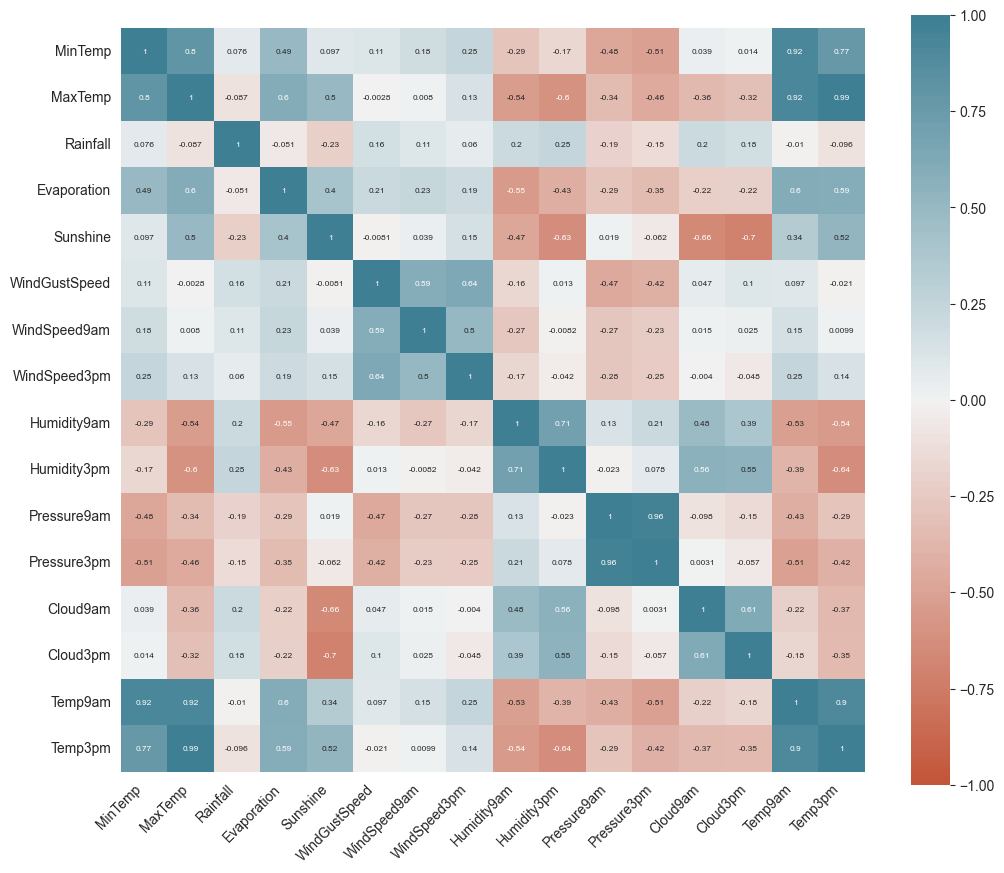

In [1267]:
x_train_corr=pd.DataFrame(x_train,columns=x_train.drop(columns=['RainToday', 'Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm']).columns)

plt.figure(figsize=(12,10))
corr = x_train_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

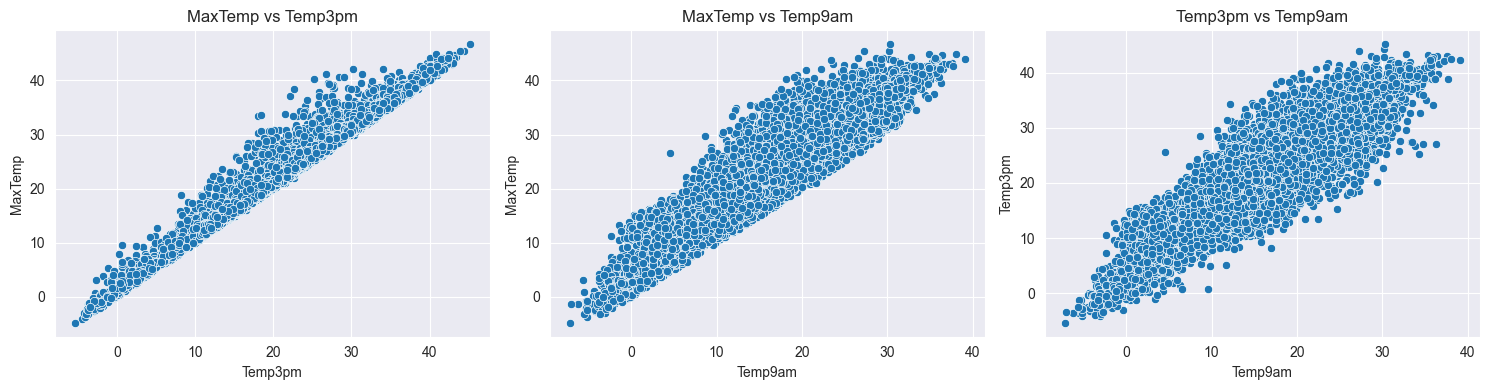

In [1268]:
# Visualización de la relación entre algunas variables

pares = [('MaxTemp', 'Temp3pm'), ('MaxTemp', 'Temp9am'), ('Temp3pm', 'Temp9am')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

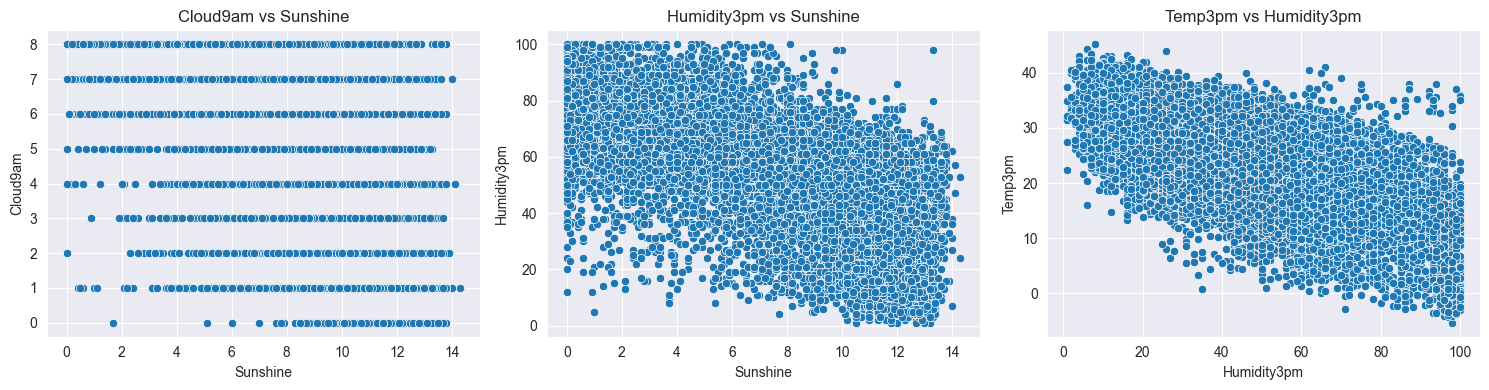

In [1269]:
# Visualización de la relación negativa entre algunas variables

pares = [('Cloud9am', 'Sunshine'), ('Humidity3pm', 'Sunshine'), ('Temp3pm', 'Humidity3pm')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

- En la **matriz de correlacion** podemos destacar múltiples variables relacionadas. 
- Se destacan varias relaciones fuertemente **positivas**, es decir, mientras aumenta una variable, la otra se comporta de la misma manera. Un claro ejemplo es ``MaxTemp`` con ``Temp9am`` y ``Temp3pm``: esta relacion es intuitiva ya que la raiz del dato que se toma es la misma, la **temperatura**. Lo mismo sucede entre ``Temp9am`` y ``Temp3pm``. Podemos observar en los gráficos hechos anteriormente cómo mientras sube la temperatura a la mañana, también lo hace a la tarde.
- Por otro lado, podemos observar variables relacionadas **negativamente**, como ``Sunshine`` con ``Cloud3pm``. Se logra apreciar cómo a medida que los niveles de nubes bajan, la duración de la luz solar aumenta. Esta relacion tambien es intuitiva, ya que si no hay nubes, el sol no será tapado.

#### Analisis por variable individual

Para poder hacer un mejor análisis sobre los datos (presencia de outliers, distribución de los datos, etc.) decidimos graficar la distribución de cada variable. Además, incluímos la variable categórica "RainToday" en cada uno de los gráficos para poder apreciar mejor si los outliers realmente eran valores atípicos, o si se justificaban por su categoría.

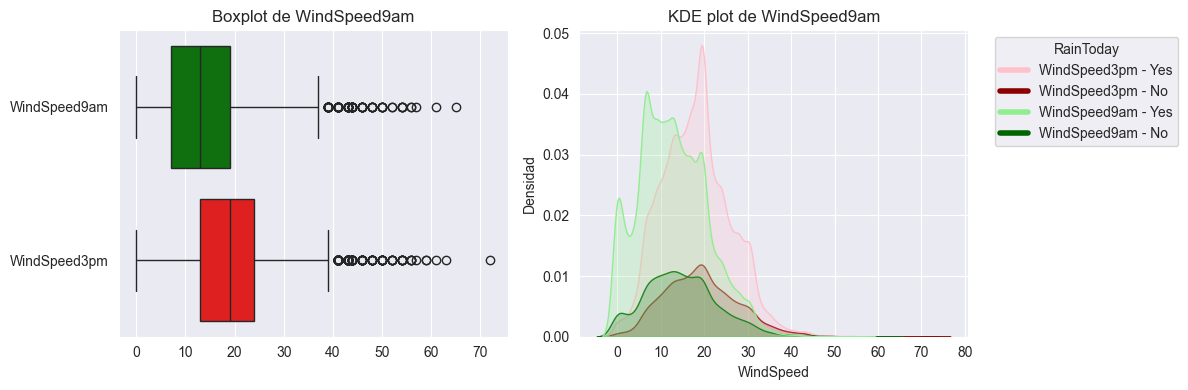

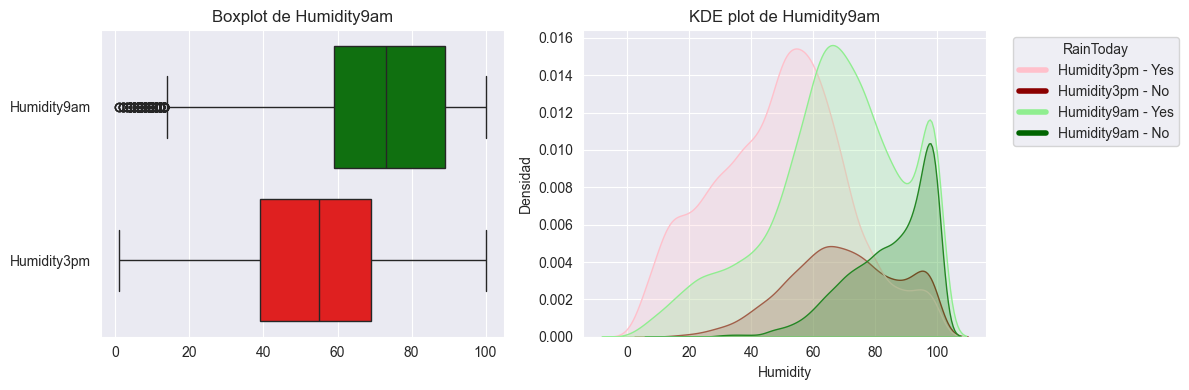

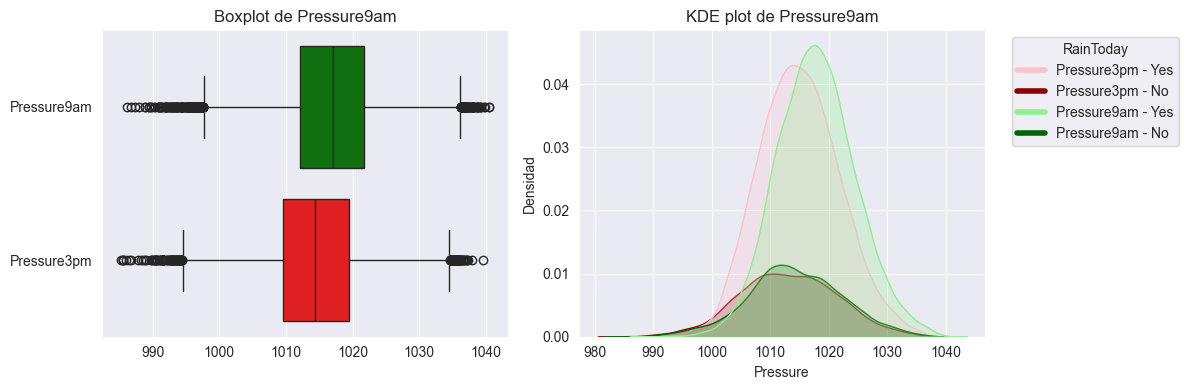

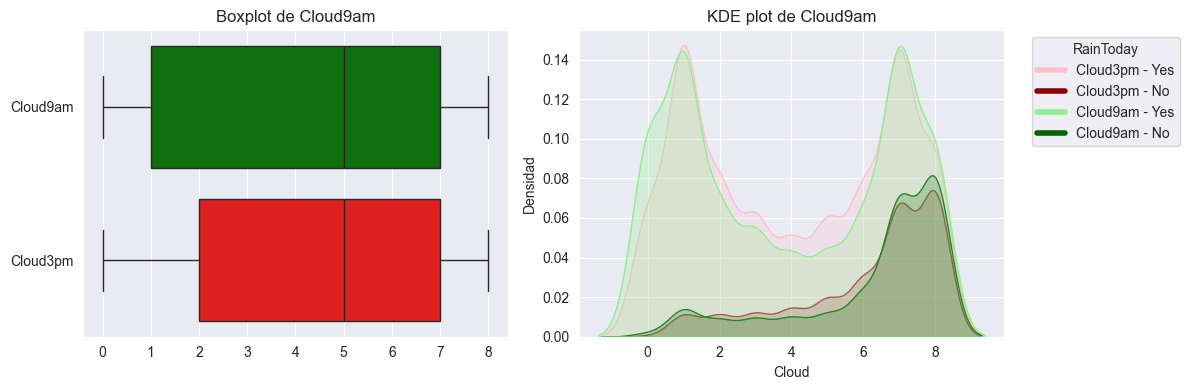

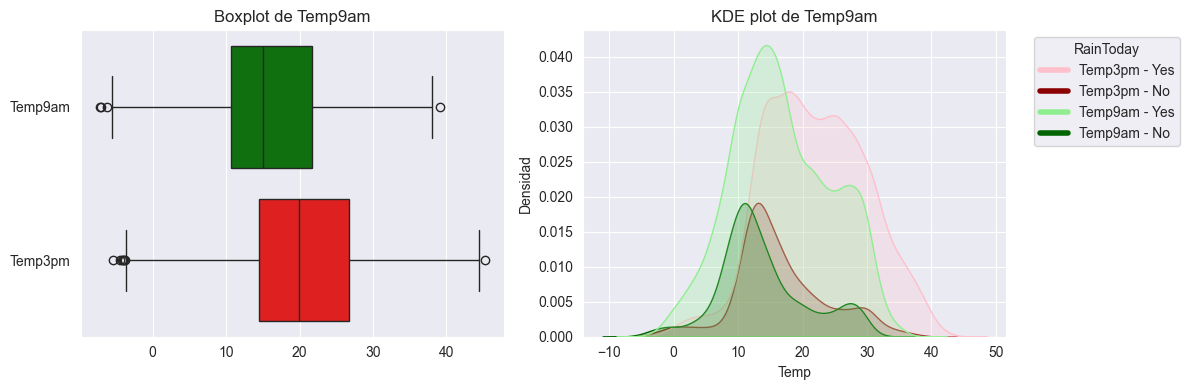

In [1270]:


x_train_grafico=pd.DataFrame(x_train,columns=x_train.drop(columns=['Date']).columns)

am_pm_list = ["WindSpeed","Humidity","Pressure","Cloud","Temp"]

sns.set_style("darkgrid")
# Definir las paletas personalizadas
palette_a = ['lightgreen', 'darkgreen']  # Verde oscuro y verde claro
palette_b = ['pink', 'darkred'] 
palette_c = ['green', 'red']           # Rojo claro y rojo oscuro
for variable in am_pm_list:

    am = variable + '9am'
    pm = variable + '3pm'
    # Crear la figura
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(data=x_train[[am,pm]], ax=axs[0], 
                palette=palette_c,orient="h")
    axs[0].set_title(f'Boxplot de {am}')

    # Graficar el KDE para Temp3pm con rojo oscuro y rojo claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=pm, fill=True, hue='RainToday', 
                palette=palette_b, label=pm)
    axs[1].set_title(f'KDE plot de {pm}')
    axs[1].set_ylabel('Densidad')


    # Graficar el KDE para Temp9am con verde oscuro y verde claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=am, fill=True, hue='RainToday', 
                palette=palette_a, label=am)
    axs[1].set_title(f'KDE plot de {am}')
    axs[1].set_ylabel('Densidad')

    # Añadir la leyenda personalizada que relacione los colores con 'Yes' y 'No'
    # Cada hue tiene 'Yes' y 'No', por lo que mostramos dos entradas para cada variable
    legend_labels = [f'{pm} - Yes', f'{pm} - No', f'{am} - Yes', f'{am} - No']
    colors = palette_b + palette_a  # Los colores que usaste

    # Crear los elementos de la leyenda

    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]

    # Colocar la leyenda en la figura
    plt.legend(handles=legend_elements, title='RainToday', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(variable)
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    x_train_grafico = x_train_grafico.drop(columns=[am,pm])





MinTemp
count    22246.000000
mean        11.141607
std          7.121336
min         -8.500000
25%          6.100000
50%         10.400000
75%         15.800000
max         30.300000
Name: MinTemp, dtype: float64 



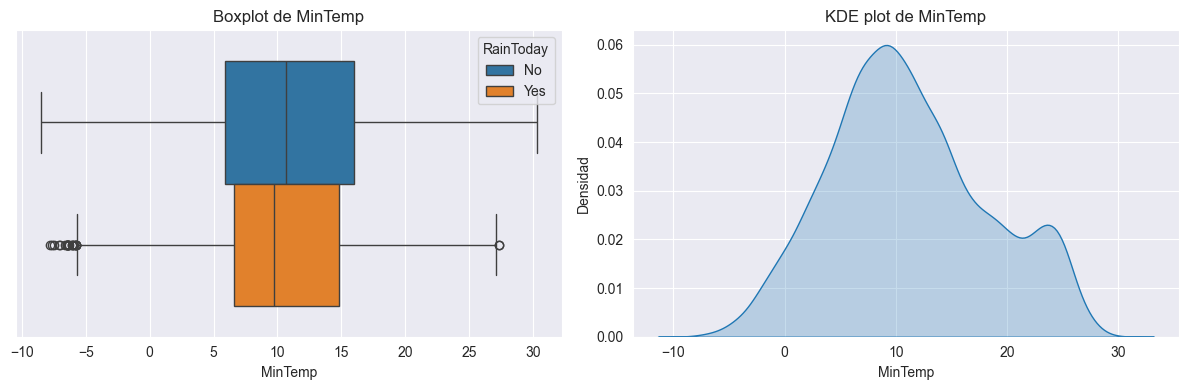

#############################################################################################
MaxTemp
count    22280.000000
mean        22.366311
std          8.440761
min         -4.800000
25%         15.800000
50%         21.600000
75%         28.900000
max         46.700000
Name: MaxTemp, dtype: float64 



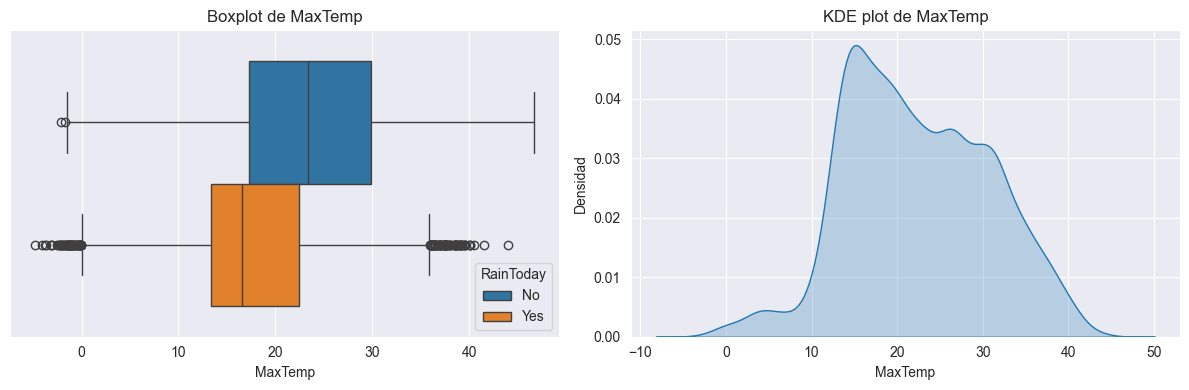

#############################################################################################
Rainfall
count    22104.000000
mean         2.340246
std          8.237004
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max        225.000000
Name: Rainfall, dtype: float64 



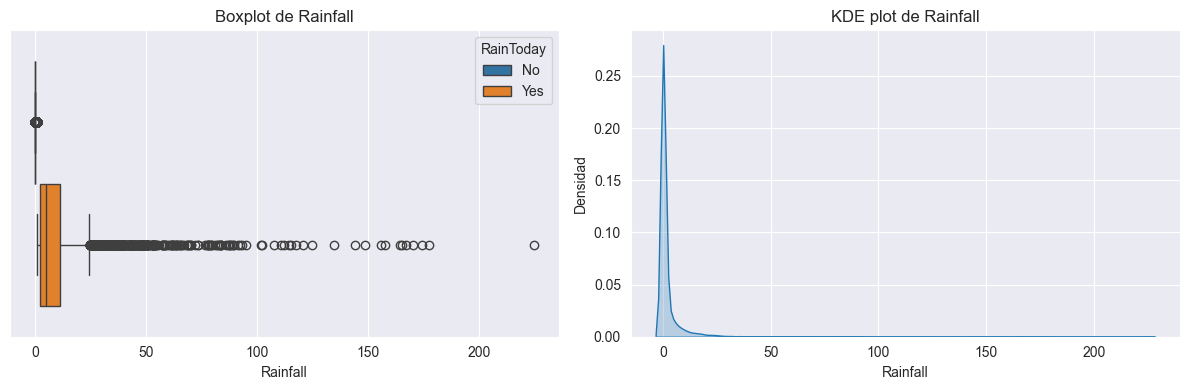

#############################################################################################
Evaporation
count    14814.000000
mean         5.802876
std          4.500180
min          0.000000
25%          2.600000
50%          5.200000
75%          8.000000
max        145.000000
Name: Evaporation, dtype: float64 



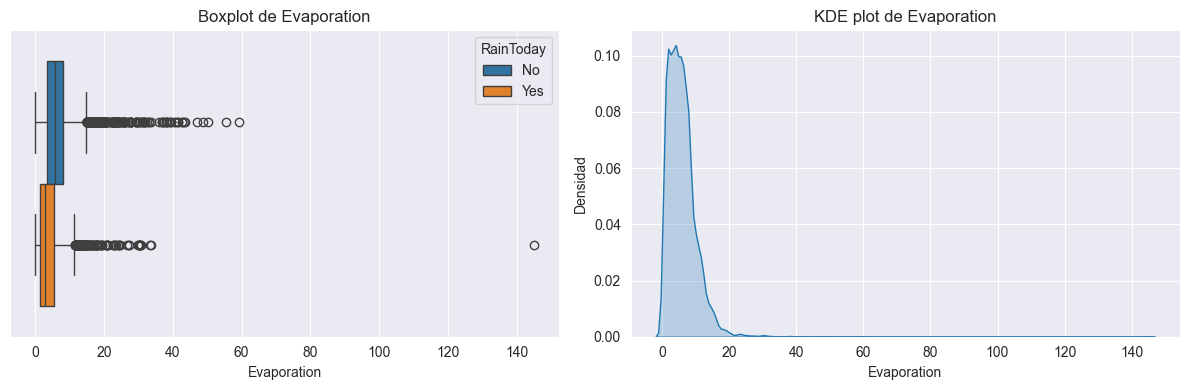

#############################################################################################
Sunshine
count    11657.000000
mean         7.424517
std          3.883891
min          0.000000
25%          4.300000
50%          8.300000
75%         10.600000
max         14.300000
Name: Sunshine, dtype: float64 



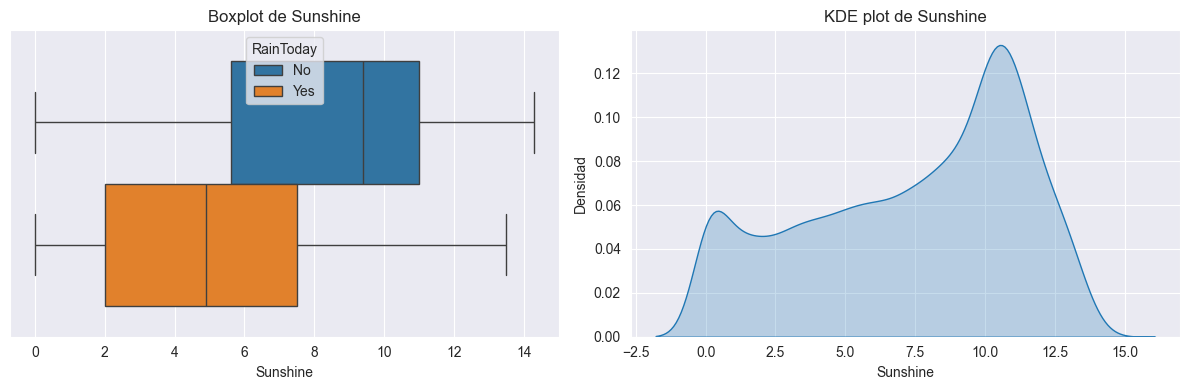

#############################################################################################
WindGustSpeed
count    21988.000000
mean        39.939967
std         13.100645
min          7.000000
25%         31.000000
50%         39.000000
75%         46.000000
max        135.000000
Name: WindGustSpeed, dtype: float64 



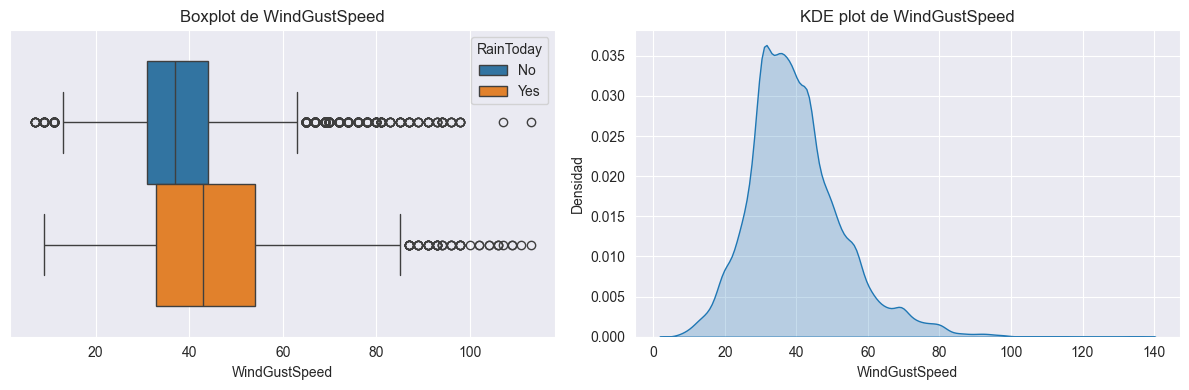

#############################################################################################
RainToday
count     22104
unique        2
top          No
freq      17013
Name: RainToday, dtype: object 



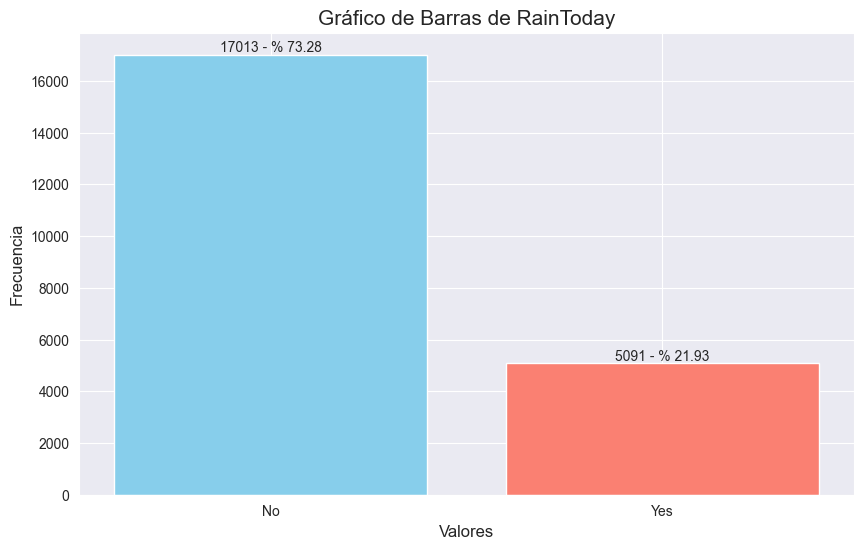

#############################################################################################
WindGustDir
count     21986
unique       16
top          NW
freq       1726
Name: WindGustDir, dtype: object 



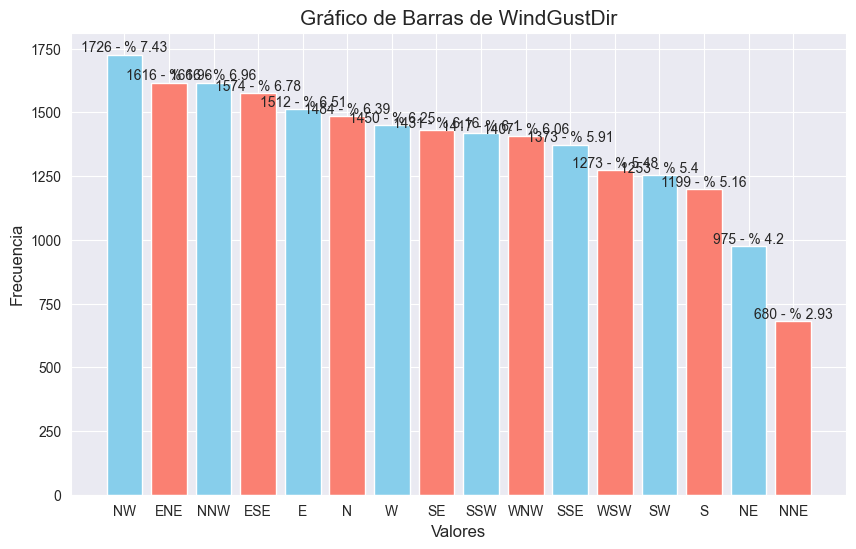

#############################################################################################
WindDir9am
count     20758
unique       16
top          SE
freq       1753
Name: WindDir9am, dtype: object 



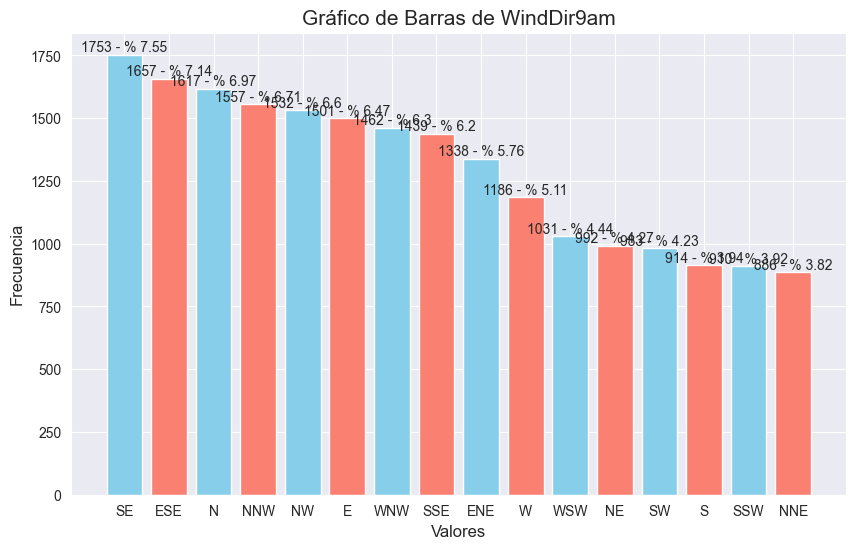

#############################################################################################
WindDir3pm
count     22087
unique       16
top         NNW
freq       1774
Name: WindDir3pm, dtype: object 



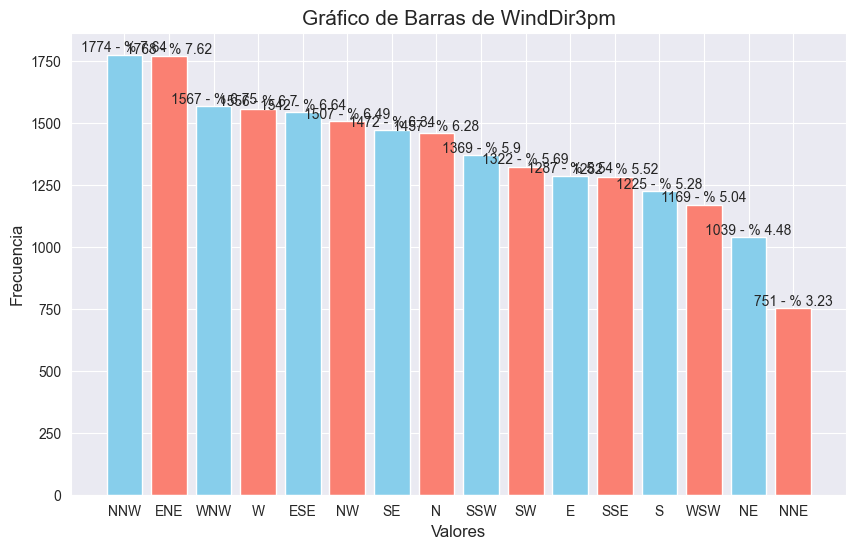

#############################################################################################


In [1271]:
for columna in x_train_grafico:
    if not columna in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        print(columna)
        print(x_train[columna].describe(), '\n')

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=x_train, x=columna, hue=f'RainToday', ax=axs[0])
        axs[0].set_title(f'Boxplot de {columna}')

        sns.kdeplot(data=x_train, x=columna, fill=True, ax=axs[1])
        axs[1].set_title(f'KDE plot de {columna}')
        axs[1].set_ylabel('Densidad')

        plt.tight_layout()
        plt.show()

        # for i in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        #     print(i)
        #     fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        #     sns.boxplot(data=x_train, x=columna, hue=f'{i}', ax=axs[0])
        #     axs[0].set_title(f'Boxplot de {columna}')

        #     '''sns.kdeplot(data=x_train, x=columna, fill=True, hue=f'{i}', ax=axs[1])
        #     axs[1].set_title(f'KDE plot de {columna}')
        #     axs[1].set_ylabel('Densidad')'''

        #     plt.tight_layout()
        #     plt.show()
        print('#############################################################################################')

for i in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    print(i)
    print(x_train[f'{i}'].describe(), '\n')

    count = x_train[f'{i}'].value_counts().reset_index()
    count.columns = ['Valores', 'Frecuencia']

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(count['Valores'].astype(str), count['Frecuencia'], color=['skyblue', 'salmon'])

    # Agregar título y etiquetas
    plt.title(f'Gráfico de Barras de {i}', fontsize=15)
    plt.xlabel('Valores', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Agregar el número encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text((bar.get_x() + bar.get_width() / 2.0), height, f'{int(height)} - % {round((int(height)/23215)*100,2)}', ha='center', va='bottom')

    # Mostrar el gráfico
    plt.show()
    print('#############################################################################################')



En base a los gráficos, se observan las siguientes distribuciones:
- WindSpeed: Distribución asimétrica a la derecha esto se justifica viendo una gran cantidad de outliers en la parte derecha del boxplot. Estos outliers se presentan para ambos horarios, ademas podemos observar que la mediana de las velocidades de vientos a la 9am es ligeramente inferior que a las 3pm. Por otro lado la influencia si llueve en el dia o no podriamos decir que no afecta a las velocidades.
- Humidity: Distribución aproximadamente normal en el horario de las 3 de la tarde mientras que a la 9 de la mañana se observa una asimetria hacia la izquierda ibteniendo en promedio mayor humedad a la mañana que a la tarde. Se puede observar como la humedad se ve afectada positivamente los dias de lluvia obteniendo puntajes mayores.
- Preassure: Distribucion aproximadamente normal con una leve asimetria hacia la izquierda debido a que se pueden observar para ambos horarios mayor cantidad de outliers a la izquierda del boxplot. Tambien podemos observar que los dias que llueve la media de la presion atmosférica es levemente menor
- Cloud: Distribución Bimodal similares para ambos horarios. Podemos observar una moda alrededor de 1 y otra alrededor de los 7 puntos. Los dias de lluvia vemos como deja de ser una distribucion bimodal, a una con una aproximadamente normal asimetrica hacia la izquierda.
- Temp: Distribución aproximadamente normal con outliers en sus dos colas con mayor frecuencioa en el lado izquierdo. Los mismos se presentan para ambos horarios. Se oberva que los dias de lluvia la termperatura en inferior.
- MinTemp: Distribución bimodal. 
- MaxTemp: Distribución apróximadamente normal. El boxplot presenta algunos outlier, los dias de lluvia la mediana de las maximas temperaturas es inferior.
- Rainfall: Distribución muy asimetrica hacia la derecha, podemos observar gran cantidad de outliers en la parte derecha del boxplot, lo que explica esta gran asimetría
- Evaporation: Al igual que Rainfall podemos observar una distribución asimétrica hacia la derecha. Tambien se observan gran cantidad de outliers tanto para los dias de lluvia como para los que no.
- Sunshine: Distribución bimodal, una muy marcada al rededor de los 10 puntos y otra mas leve al rededor de los 0 puntos. Si bien es intuitivo se observa que los dias de lluvia la mediana de los puntos de sunshine son inferiores.
- WindGustSpeed: Distribución aproximadamente normal asimétrica a la derecha. Se pueden observar outliers en la parte derecha de los boxplot. Ademas los dias de lluvia presentan una mediana mayor de WindGustSpeed
- RainToday: Podemos observar un desbalanceo en los datos dando un 76% de los datos provienen de dias que no llueven mientras que un 21% que no.
- WindGustDir: Podemos observer que los datos se distribuyen entre un 4% a 8% entre cada categoria, siendo mas frecuentes WINDGUSTDIR del sur oeste y los menos fruentes del NorNorEste
- WindDir9am: Podemos observer que los datos se distribuyen entre un 3% a 10% entre cada categoria, siendo mas frecuentes los vientos en dirección al sursuereste y los menos fruentes del oestenoroeste
- WindDir3pm: Podemos observer que los datos se distribuyen entre un 4% a 8% entre cada categoria, siendo mas frecuentes los vientos en dirección al sur oeste y los menos fruentes del estenoreste

#### Paso 3 (Imputación de datos)

En base al análisis descriptivo, decidimos utilizar distintos métodos de imputación según la distribución y el tipo de variable.

### Continuas
- MinTemp: KNN
- Temp9am: Media
- Rainfall: Mediana
- Evaporation: Mediana
- WindGustSpeed: Mediana
- Pressure3pm: Mediana
- Pressure9am: Mediana
- WindSpeed3pm: KNN
- WindSpeed9am: KNN
- Humidity3pm: KNN
- Humidity9am: KNN
- Cloud9am: KNN
- Cloud3pm: KNN
- Temp3pm: KNN
- MaxTemp: Mediana?
- Sunshine: KNN

### Cualitativas
- WindGustDir: KNN
- WindDir9am: KNN
- WindDir3pm: KNN
- RainToday: KNN

In [1272]:
# Creamos copias de los dataset
x_train_imputer = x_train.copy()
x_test_imputer = x_test.copy()

# Imputamos por la media
columns_normal = ['MaxTemp', 'Temp9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'mean', columns_normal)

# Imputamos por la mediana
columns_asimetric = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'Pressure3pm', 'Pressure9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'median', columns_asimetric)

# Imputamos por KNN
columns_bimodal = ['WindSpeed3pm', 'WindSpeed9am', 'Humidity3pm', 'Humidity9am', 'Cloud9am','Cloud3pm', 'Temp3pm', 'MinTemp','Sunshine']
knn_imputer = KNNImputer()
x_train_imputer[columns_bimodal]= knn_imputer.fit_transform(x_train_imputer[columns_bimodal])
x_test_imputer[columns_bimodal]= knn_imputer.transform(x_test_imputer[columns_bimodal])

# Verificamos
x_train_imputer.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir       321
WindGustSpeed       0
WindDir9am       1549
WindDir3pm        220
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday         203
dtype: int64

Codificación de direcciones de viento

In [1273]:
x_train_mapping = x_train_imputer.copy()
x_test_mapping = x_test_imputer.copy()

# Mapeamos las direcciones del viento a ángulos
angle_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Se mapea cada dirección a su ángulo
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    x_train_mapping[f'{col}_angulo'] = x_train_mapping[col].map(angle_map).astype(float) # Se debe transformar a float, ya que si no serán categoricas
    x_test_mapping[f'{col}_angulo'] = x_test_mapping[col].map(angle_map).astype(float)

# Convertimos los ángulos a valores seno y coseno
for col in ['WindGustDir_angulo', 'WindDir9am_angulo', 'WindDir3pm_angulo']:
    x_train_mapping[f'{col}_sin'] = np.sin(np.radians(x_train_mapping[col])) # Se pasan a radianes ya que np.sin y np.cos esperan ángulos en radianes
    x_train_mapping[f'{col}_cos'] = np.cos(np.radians(x_train_mapping[col]))
    x_test_mapping[f'{col}_sin'] = np.sin(np.radians(x_test_mapping[col]))
    x_test_mapping[f'{col}_cos'] = np.cos(np.radians(x_test_mapping[col]))

# Descartamos las columnas originales y las _angulo
x_train_mapping = x_train_mapping.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm',
                              'WindGustDir_angulo', 'WindDir9am_angulo', 'WindDir3pm_angulo'])
x_test_mapping = x_test_mapping.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm',
                             'WindGustDir_angulo', 'WindDir9am_angulo', 'WindDir3pm_angulo'])

# Visualizamos una de las nuevas columnas
x_train_mapping[['WindDir3pm_angulo_cos','WindDir3pm_angulo_sin']]

,WindDir3pm_angulo_cos,WindDir3pm_angulo_sin
93395,0.382683,9.238795e-01
143406,0.382683,-9.238795e-01
53930,-0.923880,3.826834e-01
61130,0.382683,9.238795e-01
95576,-0.382683,9.238795e-01
...,...,...
134339,-0.382683,9.238795e-01
58269,-1.000000,1.224647e-16
40445,-0.923880,-3.826834e-01
82565,0.382683,-9.238795e-01


Codificación de la fecha

In [1274]:
# Para poder mantener parte de la data de Date, aislamos el mes y luego lo codificamos.

# Mes
x_train_mapping['Month'] = x_train_mapping['Date'].dt.month
x_test_mapping['Month'] = x_test_mapping['Date'].dt.month


In [1275]:
# Codificación seno-coseno para Mes (1-12)

x_train_mapping['Month_sin'] = np.sin(2 * np.pi * x_train_mapping['Month'] / 12)
x_train_mapping['Month_cos'] = np.cos(2 * np.pi * x_train_mapping['Month'] / 12)
x_test_mapping['Month_sin'] = np.sin(2 * np.pi * x_test_mapping['Month'] / 12)
x_test_mapping['Month_cos'] = np.cos(2 * np.pi * x_test_mapping['Month'] / 12)

x_train_mapping = x_train_mapping.drop(columns=['Month'])
x_test_mapping = x_test_mapping.drop(columns=['Month'])

Utilizamos la codificación de LabelEncoder para la variable RainToday

In [1276]:
x_train_imputer_v2 = x_train_mapping.copy()
x_test_imputer_v2 = x_test_mapping.copy()

for var in ['RainToday']:
    label_encoder = LabelEncoder()
    x_train_imputer_v2[var] = label_encoder.fit_transform(x_train_imputer_v2[var])
    x_test_imputer_v2[var] = label_encoder.transform(x_test_imputer_v2[var])
    

In [1277]:
# Eliminamos la columna date
x_train_imputer_v2 = x_train_imputer_v2.drop(columns=['Date']).reset_index(drop=True)
x_test_imputer_v2 = x_test_imputer_v2.drop(columns=['Date']).reset_index(drop=True)

# Imputamos las columnas codificadas
columns_bimodal_cat = ['WindGustDir_angulo_cos','WindGustDir_angulo_sin','WindDir9am_angulo_cos','WindDir9am_angulo_sin','WindDir3pm_angulo_cos','WindDir3pm_angulo_sin','RainToday']

knn_imputer = KNNImputer()

x_train_imputer_v2[columns_bimodal_cat]= knn_imputer.fit_transform(x_train_imputer_v2[columns_bimodal_cat])
x_test_imputer_v2[columns_bimodal_cat]= knn_imputer.transform(x_test_imputer_v2[columns_bimodal_cat])

# Verificamos que no queden Null
x_train_imputer_v2.isna().sum()

MinTemp                   0
MaxTemp                   0
Rainfall                  0
Evaporation               0
Sunshine                  0
WindGustSpeed             0
WindSpeed9am              0
WindSpeed3pm              0
Humidity9am               0
Humidity3pm               0
Pressure9am               0
Pressure3pm               0
Cloud9am                  0
Cloud3pm                  0
Temp9am                   0
Temp3pm                   0
RainToday                 0
WindGustDir_angulo_sin    0
WindGustDir_angulo_cos    0
WindDir9am_angulo_sin     0
WindDir9am_angulo_cos     0
WindDir3pm_angulo_sin     0
WindDir3pm_angulo_cos     0
Month_sin                 0
Month_cos                 0
dtype: int64

In [1278]:
x_train_imputer.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

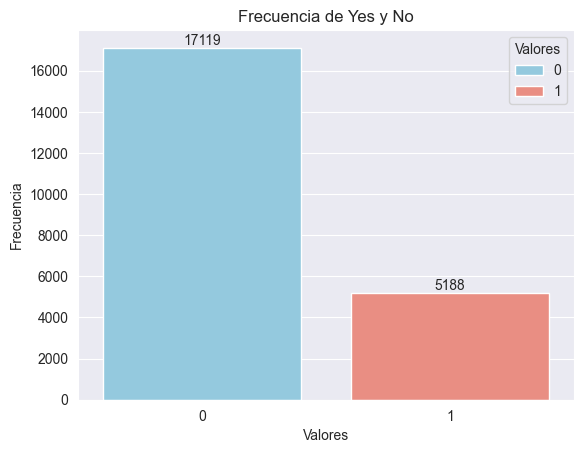

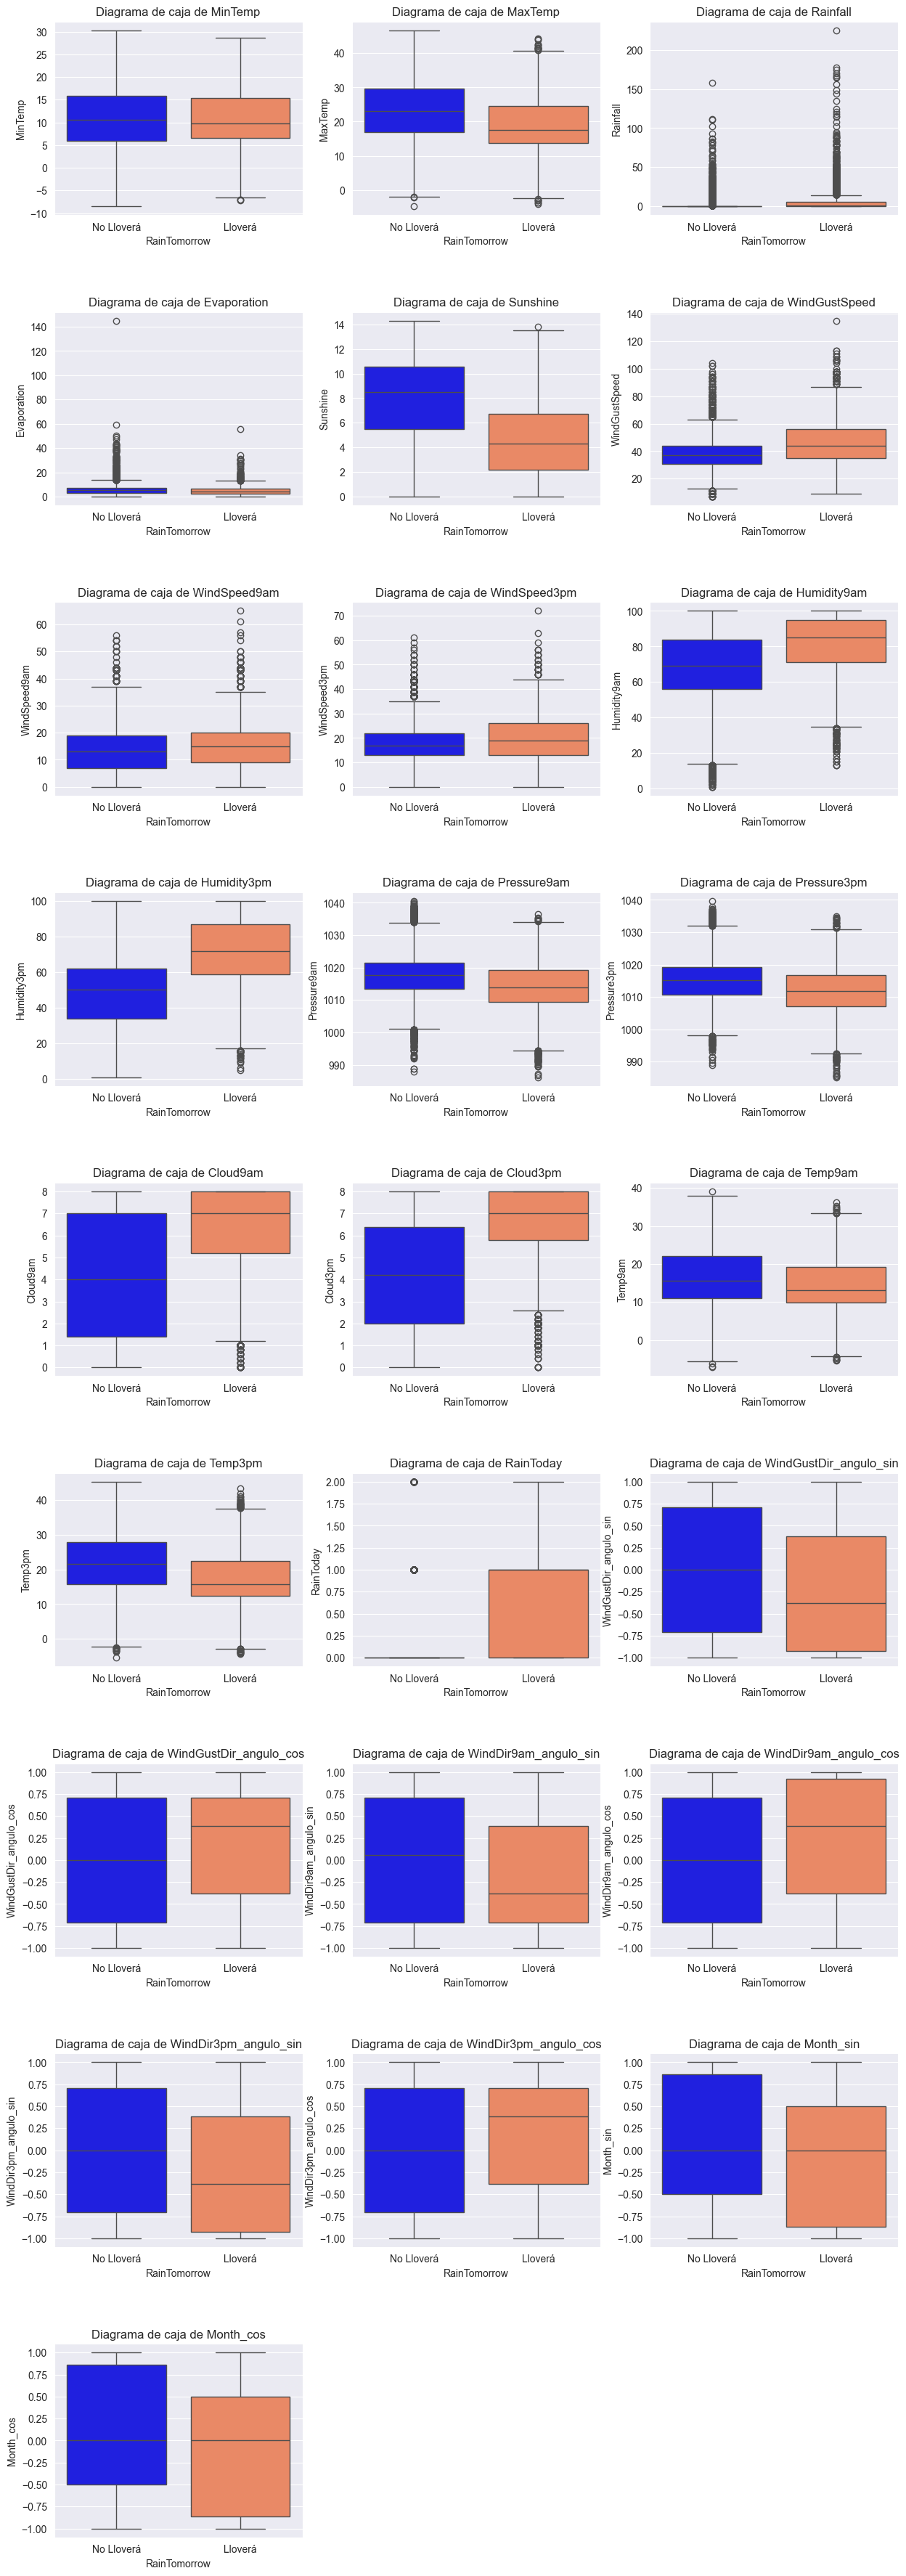

In [1279]:
# Calculamos la frecuencia de cada valor
dataframe = pd.DataFrame(y_train)
value_counts = dataframe[0].value_counts().reset_index()
value_counts.columns = ['Valores', 'Frecuencia']
sns.barplot(x='Valores', y='Frecuencia', hue='Valores', data=value_counts, palette=['skyblue', 'salmon'])

# Agregar la cantidad de cada valor encima de cada barra
for index, row in value_counts.iterrows():
    plt.text(row.name, row['Frecuencia'] + 5, str(row['Frecuencia']), ha='center', va='bottom')

plt.title('Frecuencia de Yes y No')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

boxplots(x_train_imputer_v2, y_train, x_train_imputer_v2.columns)

Podemos observar a nivel general un gran desbalanceo de datos, alrededor de 3 veces más valores negativos (17119) que positivos (5188) en nuestra variable a predecir. En términos de nuestro dataset, la cantidad de días no lluviosos es mayor a la cantidad de días lluviosos.

Es importante saber si los datos están desbalanceados, ya que si no lo están, se provocar un sesgo en el modelo a entrenar. Esto se lo podrá observar en los valores de ``recall`` entre el modelo con datos balanceados y no balanceados. 

Con nuestro balance de datos actual, nuestro modelo sin balancear podría tener mayor tendencia de asignar "No" (No lloverá mañana) a los días que clasifique.

En general, si para ambas clases se observa un nivel de recall (por clase) del 80%, esto indicaría que se obtuvo un buen fitting.

### Escalado de Datos

Debido a que vimos variables con una gran cantidad de outliers decidimos usar un escalador mas robusto que no este influenciado por los mismos

In [1280]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer_v2)
x_test_scaled = scaler.transform(x_test_imputer_v2)


# Ejercicio 2

## Regresión Logística

Luego de haber analizado los datos, codificado las variables y revisado los Nulls, procedemos con el entrenamiento del modelo de Regresión Logística.

Primero experimentamos sin ningun tipo de balanceo en los datos.

In [1281]:
y_train = y_train.to_numpy().ravel() # Transformamos en un Numpy array de 1D

## Regresión Logística - Sin balancear

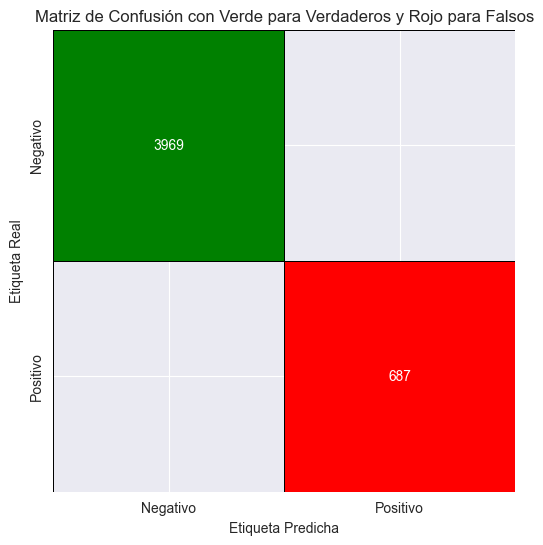

Métricas para Regresión Logística (sin balanceo):

Accuracy: 0.8348574502420656

Matriz de confusión:
[[3969  292]
 [ 629  687]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      4261
           1       0.70      0.52      0.60      1316

    accuracy                           0.83      5577
   macro avg       0.78      0.73      0.75      5577
weighted avg       0.83      0.83      0.83      5577



In [1317]:
# Creamos el modelo de Regresión logística
logistic_model = LogisticRegression(random_state=42, max_iter=200) # Incrementamos las iteraciones así puede converger
logistic_model.fit(x_train_scaled, y_train)

y_pred = logistic_model.predict(x_test_scaled)

# Visualizamos las métricas
logRegMetrics(y_test,y_pred,'Regresión Logística (sin balanceo)')

Si bien se obtuvo una ``Accuracy`` alta (0.83), esta métrica no es ideal para datasets desbalanceados. Esto se debe al sesgo que tendrá el modelo, ya que asignará la variable con más frecuencia (en este caso, "No") a una mayor cantidad de datos.

Además, se obtuvo un valor ``Recall`` de 0.93 para _No_ y 0.52 para _Yes_. ``Recall`` describe, dentro de una misma clase, cuántas fueron correctamente clasificadas.  
Esto también pone en evidencia el desbalance del dataset, ya que se obtuvo un muy buen valor de ``Recall`` para los negativos, pero no para los positivos.

En cuanto a la ``Precisión``, esta métrica mide cuántas de las clases clasificadas como positivas realmente lo son. Cuántos menos falsos positivos (FP), más alto será este valor. Podemos observar que la ``Precision`` para los valores negativos fue más alta que para los positivos, lo cual también se justifica con el desbalanceo del dataset.

En la matríz de confusión se observan: 
- TN (Verdaderos Negativos): 3969
- FP (Falsos positivos): 292
- FN (Falsos negativos): 629
- TP (Verdaderos positivos): 687


Umbral del punto más cercano a (0,1): 0.2573470449587585
Punto más cercano a (0,1): (0.19, 0.77)


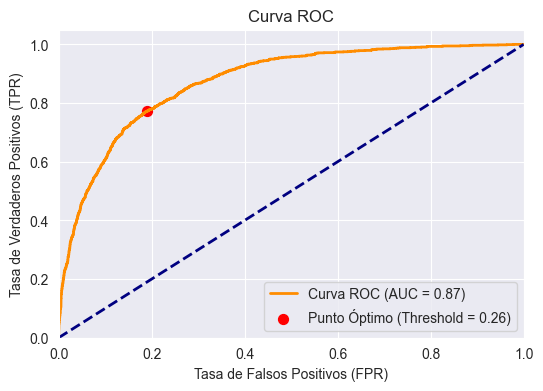

In [1283]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logistic_model.predict_proba(x_test_scaled)[:, 1]

logistic_model_th = curvaRocCustom(y_test,y_probs)

In [1284]:
y_pred_custom = (y_probs >= logistic_model_th).astype(int)

logRegMetrics(y_test,y_pred_custom,'Regresión Logística (sin balanceo - con umbral óptimo)')

Métricas para Regresión Logística (sin balanceo - con umbral óptimo):

Accuracy: 0.8016854939931863

Matriz de confusión:
[[3454  807]
 [ 299 1017]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4261
           1       0.56      0.77      0.65      1316

    accuracy                           0.80      5577
   macro avg       0.74      0.79      0.75      5577
weighted avg       0.83      0.80      0.81      5577



Podemos observar que la cantidad de TP (Verdaderos positivos) ha aumentado drásticamente luego de la optimización de umbral (ha pasado de 687 a 1017). Sin embargo, también ha aumentado la cantidad de FP (Falsos positivos) lo cual impacta la métrica de ``Precisión`` para los positivos.

## Regresión Logística - Balanceo "Balanced"

In [1320]:
# Creamos el modelo de Regresión logística
logistic_weight_balanced = LogisticRegression(random_state=42, class_weight='balanced', max_iter=200)
logistic_weight_balanced.fit(x_train_scaled, y_train)
y_pred = logistic_weight_balanced.predict(x_test_scaled)

logRegMetrics(y_test,y_pred,'Regresión Logística (balanceo "Balanced")')

Métricas para Regresión Logística (balanceo "Balanced"):

Accuracy: 0.7894925587233279

Matriz de confusión:
[[3361  900]
 [ 274 1042]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4261
           1       0.54      0.79      0.64      1316

    accuracy                           0.79      5577
   macro avg       0.73      0.79      0.75      5577
weighted avg       0.83      0.79      0.80      5577



Umbral del punto más cercano a (0,1): 0.5040172701700874
Punto más cercano a (0,1): (0.21, 0.79)


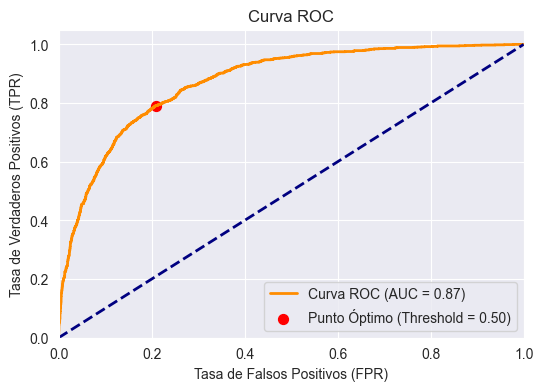

In [1286]:
# Obtengo las probabilidades de predicción del modelo
y_probs2 = logistic_weight_balanced.predict_proba(x_test_scaled)[:, 1]

logistic_balanced_th = curvaRocCustom(y_test,y_probs2)


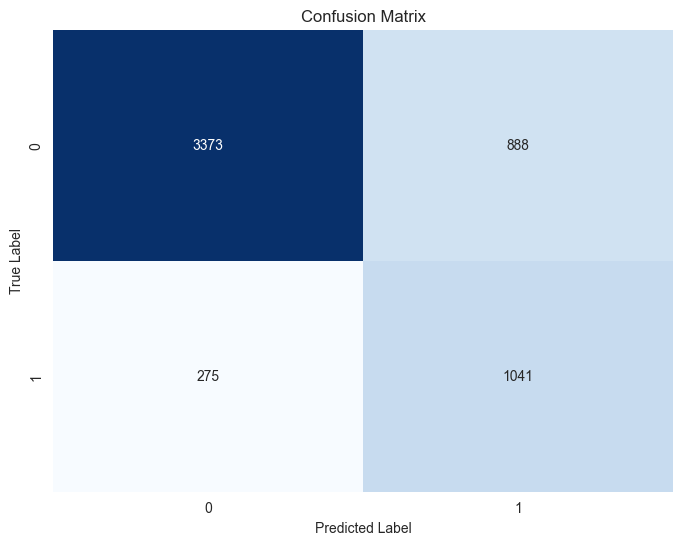

Métricas para Regresión Logística (balanceo "Balanced" - con umbral óptimo):

Accuracy: 0.7914649453110991

Matriz de confusión:
[[3373  888]
 [ 275 1041]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4261
           1       0.54      0.79      0.64      1316

    accuracy                           0.79      5577
   macro avg       0.73      0.79      0.75      5577
weighted avg       0.83      0.79      0.80      5577



In [1298]:
y_pred_custom = (y_probs2 >= logistic_balanced_th).astype(int)

logRegMetrics(y_test, y_pred_custom, 'Regresión Logística (balanceo "Balanced" - con umbral óptimo)')

## Regresión Logística - Balanceo SMOTE

In [1288]:
# Balanceo con SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

In [1289]:
logistic_SMOTE = LogisticRegression(random_state=42, max_iter=200)
logistic_SMOTE.fit(x_train_resampled, y_train_resampled)
y_pred = logistic_SMOTE.predict(x_test_scaled)

logRegMetrics(y_test, y_pred, 'Regresión Logística (balanceo SMOTE)')

Métricas para Regresión Logística (balanceo SMOTE):

Accuracy: 0.7896718665949435

Matriz de confusión:
[[3363  898]
 [ 275 1041]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4261
           1       0.54      0.79      0.64      1316

    accuracy                           0.79      5577
   macro avg       0.73      0.79      0.75      5577
weighted avg       0.83      0.79      0.80      5577



Umbral del punto más cercano a (0,1): 0.5096243180658141
Punto más cercano a (0,1): (0.2, 0.79)


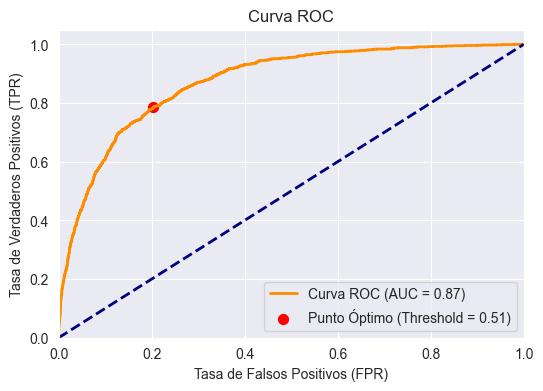

In [1290]:
# Obtengo las probabilidades de predicción del modelo
y_probs3 = logistic_SMOTE.predict_proba(x_test_scaled)[:, 1]

logistic_SMOTE_th = curvaRocCustom(y_test,y_probs3)

In [1291]:
y_pred_custom = (y_probs3 >= logistic_SMOTE_th).astype(int)

logRegMetrics(y_test, y_pred_custom, 'Regresión Logística (balanceo SMOTE - con umbral óptimo)')

Métricas para Regresión Logística (balanceo SMOTE - con umbral óptimo):

Accuracy: 0.7939752555137171

Matriz de confusión:
[[3393  868]
 [ 281 1035]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      4261
           1       0.54      0.79      0.64      1316

    accuracy                           0.79      5577
   macro avg       0.73      0.79      0.75      5577
weighted avg       0.83      0.79      0.81      5577



## Modelo base

In [1292]:
dummy_clf = DummyClassifier(strategy="stratified",random_state=42)
dummy_clf.fit(x_train_scaled, y_train)
dummy_pred = dummy_clf.predict(x_test_scaled)

logRegMetrics(y_test, dummy_pred, 'DummyClassifier')

Métricas para DummyClassifier:

Accuracy: 0.6480186480186481

Matriz de confusión:
[[3301  960]
 [1003  313]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4261
           1       0.25      0.24      0.24      1316

    accuracy                           0.65      5577
   macro avg       0.51      0.51      0.51      5577
weighted avg       0.64      0.65      0.65      5577



Utilizamos un ``DummyClassifier`` que genera predicciones sin utilizar ninguna relación entre las características de los datos y las etiquetas. En este caso,utilizamos la estrategia ``stratified``, lo que significa que las predicciones de la clase se asignan de manera aleatoria, pero respetando la distribución de clases de los datos de entrenamiento. 

Dado que se utilizó un ``DummyClassifier``, el desempeño no es representativo de un modelo real, ya que no aprende patrones significativos. Aunque se obtuvo una ``Accuracy`` de 0.65, esta métrica en este contexto no tiene mucho valor, ya que simplemente refleja la proporción de clases en los datos, sin que el modelo esté aprovechando ninguna información real.
Lo mismo ocurre con ``Recall``. Vemos que logra identificar correctamente el 77% de los casos de la clase mayoritaria ("No") pero solo el 24% de la clase minoritaria ("Yes"). Este resultado muestra la limitación del ``DummyClassifier``, que no tiene la capacidad de captar la clase minoritaria de manera efectiva.

En la matriz de confusión, vemos:

- TN (Verdaderos Negativos): 3301
- FP (Falsos Positivos): 960
- FN (Falsos Negativos): 1003
- TP (Verdaderos Positivos): 31

Umbral del punto más cercano a (0,1): 1.0
Punto más cercano a (0,1): (0.23, 0.24)


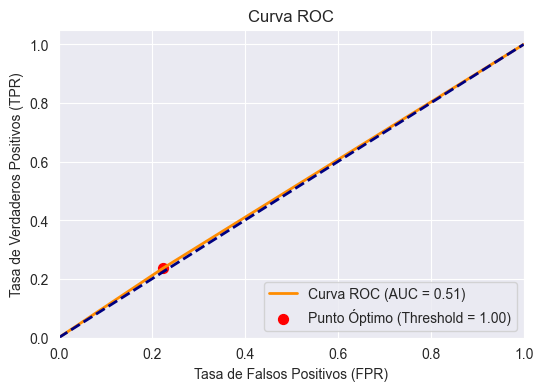

In [1293]:
# Obtengo las probabilidades de predicción del modelo
y_probs_dummy = dummy_clf.predict_proba(x_test_scaled)[:, 1]

logistic_dummy_th = curvaRocCustom(y_test,y_probs_dummy)

El área debajo de la curva (AUC) dio 0.51. Esto ocurre cuando el modelo no tiene capacidad discriminativa, lo cual es correcto, ya que nuestro DummyClassifier está clasificando de manera totalmente aleatoria. 

In [1294]:
y_pred_custom = (y_probs_dummy >= logistic_dummy_th).astype(int)

logRegMetrics(y_test, y_pred_custom, 'DummyClassifier (con umbral óptimo)')

Métricas para DummyClassifier (con umbral óptimo):

Accuracy: 0.6480186480186481

Matriz de confusión:
[[3301  960]
 [1003  313]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4261
           1       0.25      0.24      0.24      1316

    accuracy                           0.65      5577
   macro avg       0.51      0.51      0.51      5577
weighted avg       0.64      0.65      0.65      5577



## Conclusiones

Pudimos observar que al implementar el umbral óptimo en nuestros modelos, las metricas mejoran. Al elegir el punto que más se aproxima a (0,1), estamos optimizando el TPR, lo que nos da un modelo que predice mejor. También podemos determinar que, para modelos balanceados, un umbral cercano a 0.5 es el ideal. En el caso del modelo con los datos no balanceados, el umbral nos dio más cercano a 0, lo cual se explica, ya que nuestra variable a predecir presenta mayormente valores negativos que positivos.

En base a las matrices de confusión pudimos sacar las siguientes conclusiones:
- **Falsos Positivos (FP):** Estos son casos en los que el modelo predijo la clase positiva ("Yes") cuando en realidad era negativa ("No"). En el modelo sin balancear, debido a la consecuencia de tener mayor cantidad de valores negativos que positivos en nuestra variable respuesta, el número de falsos positivos es menor que en los modelos que utilizaron datos balanceados. Esto se debe a que el modelo sin balancear se ajusta mejor para los datos con mayor frecuencia. Entre los modelos balanceados se obtuvieron cantidades de falsos positivos similares.
- **Falsos Negativos (FN):** Estos son casos en los que el modelo predijo la clase negativa ("No") cuando en realidad era positiva ("Yes"). En este caso pasa lo opuesto a lo dicho anteriormente: en el modelo balanceado tienen la misma cantidad de falsos negativos que verdaderos positivos. Esto nos quiere decir que predijo mal el 50% de los valores positivos; se evidencia el desbalanceo mencionado anteriormente. Para los modelos balanceados podemos ver cómo el número de falsos negativos disminuye drásticamente, ya que son modelos que predicen mejor los valores positivos.